In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

### 产生摇臂

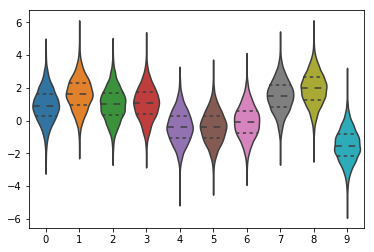

In [2]:
# 10个摇臂的编号，从0开始
K = np.array(range(10))
# 摇臂的奖赏：sigma为1的正态分布，mu不同，下面是生成mu的
R_mu = np.array([np.random.uniform(-2,2) for i in range(10)])
def K_Reward(R_mu_):
    return np.random.normal(loc=R_mu_, scale=1.0)

# 产生5000个样本，查看摇臂图像
demoData = np.array([
    [K_Reward(R_mu[i]) for i in range(R_mu.shape[0])]
    for j in range(5000)])
sns.violinplot(data=demoData, inner="quartile")
del demoData

### epsilon-贪心算法

In [3]:
def greed_epsilon(R_mu, t, epsilon):
    # 输入摇臂分布、测试次数、epsilon
    reward = 0
    array = []
    # 每个摇臂的摇到的次数、价值
    count = dict(zip(list(range(R_mu.shape[0])), [0]*R_mu.shape[0]))
    Q = dict(zip(list(range(R_mu.shape[0])), [0]*R_mu.shape[0]))
    
    for i in range(t):
        if np.random.uniform(0, 1) < epsilon:
            k = np.random.randint(0, R_mu.shape[0])
        else:
            k = max(Q, key=Q.get)
        
        reward_current = K_Reward(R_mu_=R_mu[k])
        reward += reward_current
        Q[k] = (Q[k]*count[k] + reward_current) / (count[k] + 1)
        count[k] = count[k] + 1
        array.append(reward / (i+1))
    
    return array

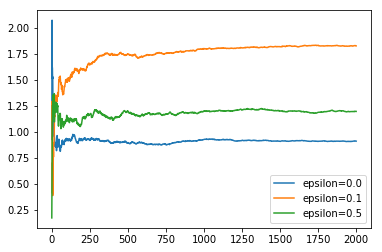

In [4]:
# excute and plot
t = 2000
T = np.arange(t)
demo_0dot0 = greed_epsilon(R_mu, t, epsilon=0.0)
demo_0dot1 = greed_epsilon(R_mu, t, epsilon=0.1)
demo_0dot5 = greed_epsilon(R_mu, t, epsilon=0.5)

plt.plot(T, demo_0dot0)
plt.plot(T, demo_0dot1)
plt.plot(T, demo_0dot5)
plt.legend(("epsilon=0.0","epsilon=0.1","epsilon=0.5"))
plt.show()

如上图，可以注意到，在迭代次数500后，epsilon=0.1的贪心算法效果几乎总比其他两个好；其原因可能有：
- 比0.0好是因为其不陷入局部最优解，总有跳出去“探索exploration”的可能；
- 比0.5好是因为其能有效利用现有信息，选择较好的摇臂。